In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
from proj1_helpers import load_csv_data, predict_labels, create_csv_submission
from implementations import least_squares_GD, least_squares_SGD, least_squares, ridge_regression, batch_iter, ridge_GD, ridge_SGD
from preprocessing import standardize_train, standardize_test, add_bias
from losses_gradients import compute_loss_ls, compute_gradient_least_squares, compute_loss_ridge, compute_gradient_ridge
from plots import plot_train_test
import math

## Load data

In [3]:
y_train, input_train, ids_train = load_csv_data('train.csv', sub_sample=False)
y_test, input_test, ids_test = load_csv_data('test.csv', sub_sample=False)

## Pre-processing

In [4]:
# IDEE: on pourrait ausi tenter build_polynomial comme dans les séries si on est motivés

In [5]:
# Standardise data
# Careful to standardize the x_test with the mean and std of x_train
x_train, mean, std = standardize_train(input_train)
x_train = add_bias(x_train)
x_test = standardize_test(input_test, mean, std)
x_test = add_bias(x_test)

## Constant definitions

In [12]:
nb_cross_validation = 10

In [17]:
# Define the parameters of the algorithm. (probably change afterwards)
max_iters = 200   #les plots sont moches parce que j'ai fait avec 20 ici                                  
batch_size = 1

# Initialization
w_initial = np.random.rand(x_train.shape[1])

In [51]:
# For grid search of hyperparameters
num_intervals = 15
gammas = np.linspace(0, 0.90, num_intervals)
lambdas = np.logspace(-4, -0.05, num_intervals)

### En fait, je sais pas si je fais n'importe quoi. Au lieu de compute loss pour y_test, peut-être que il faudrait plutôt prédire y_pred et comparer y_test pour avoir l'accuracy.
Vous en pensez quoi ?

## GD Least squares

In [22]:
def ls_gd_hyperparam(gammas, nb_cross_validation):
    loss_test = np.zeros([len(gammas), nb_cross_validation])
    loss_train = np.zeros([len(gammas), nb_cross_validation])
    for i, gamma in enumerate(gammas):
        for j in range(nb_cross_validation):
            w, loss_tr = least_squares_GD(y_train, x_train, w_initial, max_iters, gamma)
            loss_train[i][j] = loss_tr
            loss_test[i][j] = compute_loss_ls(y_test, x_test, w)
    return loss_test, loss_train 

In [25]:
loss_test_gd, loss_train_gd = ls_gd_hyperparam(gammas, nb_cross_validation)

In [34]:
train_gd_mean = np.mean(loss_train_gd, axis=1)
test_gd_mean = np.mean(loss_test_gd, axis=1)

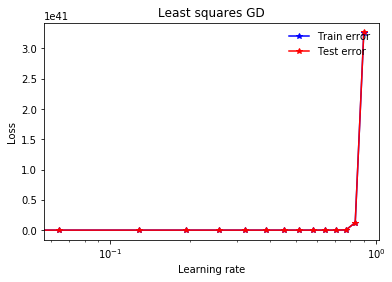

In [38]:
#Schéma moche parce que nb_iter bien trop faible
plot_train_test(train_gd_mean, test_gd_mean, gammas, "Least squares GD")

In [39]:
# Minimum values for ls_gd
idx = np.argmin(test_gd_mean)
learning_rate = gammas[idx]
ls_gd_loss = np.min(test_gd_mean)
print(learning_rate)
print(ls_gd_loss)

0.0642857142857143
0.8006996214017192


# SGD Least squares

In [41]:
def ls_sgd_hyperparam(gammas, nb_cross_validation):
    loss_test = np.zeros([len(gammas), nb_cross_validation])
    loss_train = np.zeros([len(gammas), nb_cross_validation])
    for i, gamma in enumerate(gammas):
        for j in range(nb_cross_validation):
            w, loss_tr = least_squares_SGD(y_train, x_train, w_initial, max_iters, gamma)
            loss_train[i][j] = loss_tr
            loss_test[i][j] = compute_loss_ls(y_test, x_test, w)
    return loss_test, loss_train 

In [42]:
loss_test_sgd, loss_train_sgd = ls_sgd_hyperparam(gammas, nb_cross_validation)

In [43]:
train_sgd_mean = np.mean(loss_train_sgd, axis=1)
test_sgd_mean = np.mean(loss_test_sgd, axis=1)

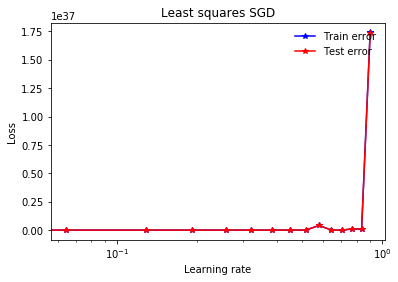

In [45]:
plot_train_test(train_sgd_mean, test_sgd_mean, gammas, "Least squares SGD")

In [46]:
# Minimum values for ls_sgd
idx = np.argmin(test_sgd_mean)
learning_rate = gammas[idx]
ls_sgd_loss = np.min(test_sgd_mean)
print(learning_rate)
print(ls_sgd_loss)

0.0
31.593116971780763


## SGD Ridge regression

In [54]:
def ridge_sgd_hyperparam(gammas, lambdas, nb_cross_validation):
    loss_train = np.zeros([len(gammas), len(lambdas), nb_cross_validation])
    loss_test = np.zeros([len(gammas), len(lambdas), nb_cross_validation])
    for i, gamma in enumerate(gammas):
        for j, lambda_ in enumerate(lambdas):
            for k in range(nb_cross_validation):
                w, loss_gamma = ridge_SGD(y_train, x_train, w_initial, max_iters, gamma, lambda_)
                loss_train[i][j][k] = loss_gamma
                loss_test[i][j][k] = compute_loss_ridge(y_test, x_test, w, lambda_)
    return loss_train, loss_test

In [ ]:
loss_test_r_sgd, loss_train_r_sgd = ridge_sgd_hyperparam(gammas, lambdas, nb_cross_validation)

In [ ]:
train_sgd_mean = np.mean(loss_train_r_sgd, axis=2)
test_sgd_mean = np.mean(loss_test_r_sgd, axis=2)

In [ ]:
# TODO: Plot 2D à coder

In [ ]:
# Minimum values for ls_sgd
ind = np.unravel_index(np.argmin(test_sgd_mean, axis=None), test_sgd_mean.shape)
learning_rate = gammas[ind[0]]
ls_sgd_loss = test_sgd_mean[ind]
print(learning_rate)
print(ls_sgd_loss)

## GD Ridge regression

In [31]:
def ridge_gd_hyperparam(gammas, lambdas, nb_cross_validation):
    loss_train = np.zeros([len(gammas), len(lambdas), nb_cross_validation])
    loss_test = np.zeros([len(gammas), len(lambdas), nb_cross_validation])
    for i, gamma in enumerate(gammas):
        for j, lambda_ in enumerate(lambdas):
            for k in range(nb_cross_validation):
                w, loss_gamma = ridge_GD(y_train, x_train, w_initial, max_iters, gamma, lambda_)
                loss_train[i][j][k] = loss_gamma
                loss_test[i][j][k] = compute_loss_ridge(y_test, x_test, w, lambda_)
    return loss_train, loss_test

In [ ]:
loss_test_r_gd, loss_train_r_gd = ridge_gd_hyperparam(gammas, lambdas, nb_cross_validation)

In [ ]:
train_gd_mean = np.mean(loss_train_r_gd, axis=2)
test_gd_mean = np.mean(loss_test_r_gd, axis=2)

In [ ]:
#TODO plot 2D

In [ ]:
# Minimum values for ls_sgd
ind = np.unravel_index(np.argmin(test_gd_mean, axis=None), test_gd_mean.shape)
learning_rate = gammas[ind[0]]
ls_gd_loss = test_gd_mean[ind]
print(learning_rate)
print(ls_gd_loss)

# Pas encore en fonction car pas sûre. Voir correction lab05

## Logistic regression
Debugged but not sure from here: Il y aura probablement une correction du labo 5 pour améliorer / vérifier les fonctions de logistic regression

### Il y a un NaN dans la loss à cause d'un outlier. Je sais pas si on choisis d'enlever ou comment traiter. On verra.

In [228]:
def sigmoid(tx, w):
    """Compute sigmoid function"""
    z = np.array(np.exp(-tx.dot(w)))
    return 1./(1 + z)

value = sigmoid(x_train, w_initial)
print(value)

[0.99981039 0.90820056 0.92786083 ... 0.28142199 0.00709906 0.04907172]


In [226]:
def compute_logreg_loss(y, tx, w):  #np.log parce que math.log fonctionne pas.. J'ai toujours pas compris pourquoi.
    """Compute error and gradient of logistic regression"""
    sig = sigmoid(tx, w)
    loss = np.sum((-y * np.log(sig) - (1-y) * np.log(1-sig)), axis = -1)/len(y)
    print(max(sig))
    #a = (-y * np.log(sig) - (1-y) * np.log(1-sig))
    #print(max(a))
    return loss

In [227]:
loss = compute_logreg_loss(y_train, x_train, w_initial)
print("loss is {}".format(loss))

[0.51459227 0.10073464 0.53488351 0.42669814 0.02003378 0.140064
 0.2264286  0.072293   0.49416143 0.6004996  0.14155126 0.00350222
 0.81835964 0.2093738  0.7436304  0.88667924 0.88977018 0.11193385
 0.70287969 0.70028424 0.34716633 0.66417114 0.94782936 0.73171242
 0.5700489  0.53273724 0.82729083 0.43374625 0.09599914 0.22535177
 0.38780099]
1.0
loss is nan


C:\Users\Pauli\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\Pauli\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


In [119]:
def compute_logreg_grad(y, tx, w):
    """Compute error and gradient of logistic regression""" 
    sig = sigmoid(tx, w)
    err  = sig - y
    grad = tx.T.dot(err)/len(y)
    return grad

In [ ]:
grad_lr = compute_logreg_grad(y_train, x_train, w_initial)
print("grad is {} \n of shape {}".format(grad_lr, grad_lr.shape))

In [ ]:
gamma = 0.01
def logistic_regression(y, tx, initial_w, max_iters, gamma): #SGD  (GD easy to implement from here)
    """Stochastic Gradient Descent algorithm with logistic regression."""
    """Required by project description"""
    w = initial_w

    for n_iter in range(max_iters):
        for y_batch, tx_batch in batch_iter(y, tx, batch_size=batch_size, num_batches=1):
            # compute a stochastic gradient
            grad = compute_logreg_grad(y_batch, tx_batch, w)
            # update w through the stochastic gradient update
            w = w - gamma * grad
            # compute a stochastic loss
            compute_logreg_loss(y_batch, tx_batch, w)
    return w, loss

In [ ]:
w_lr, loss_lr = logistic_regression(y_train, x_train, w_initial, max_iters, gamma)
print("w is {} \n of shape {}".format(w_lr, w_lr.shape))
print("\n loss of ridge_SGD is {}".format(loss_lr))

## Regularized Logistic Regression

In [ ]:
def compute_logreg_reg_loss(y, tx, w, lambda_):
    """Compute error and gradient of logistic regression"""
    reg = ( lambda_/(2*len(y)) ) * sum(w**2)
    loss = compute_logreg_loss(y, tx, w) + reg
    return loss

In [ ]:
loss_lrr = compute_logreg_reg_loss(y_train, x_train, w_initial, lambda_)
print("loss is {}".format(loss_lrr))

In [ ]:
def compute_logreg_reg_grad(y, tx, w, lambda_):
    """Compute error and gradient of logistic regression"""     
    grad = compute_logreg_grad(y, tx, w) 
    reg = (lambda_/len(y)) * w[1:]
    grad[1:] = grad[1:] + reg            
    return grad

In [ ]:
grad_lrr = compute_logreg_reg_grad(y_train, x_train, w_initial, lambda_)
print("grad is {} \n of shape {}".format(grad_lrr, grad_lrr.shape))

In [ ]:
###########
# La loss de ridge SGD me semble particulièrement haute. A vérifier avec les plots (et/ou code).
gamma = 0.01
def reg_logistic_regression(y, tx, lambda_, initial_w, max_iters, gamma):
    """Stochastic Gradient Descent algorithm with REGULARIZED logistic regression."""
    """Required by project description"""
    w = initial_w

    for n_iter in range(max_iters):
        for y_batch, tx_batch in batch_iter(y, tx, batch_size=batch_size, num_batches=1):
            # compute a stochastic gradient
            grad = compute_logreg_reg_grad(y_batch, tx_batch, w, lambda_)
            # update w through the stochastic gradient update
            w = w - gamma * grad
            # compute a stochastic loss
            loss = compute_logreg_reg_loss(y_batch, tx_batch, w, lambda_)
    return w_rlr_sgd, loss_rlr_sgd

In [ ]:
w_rlr_sgd, loss_rlr_sgd = reg_logistic_regression(y_train, x_train, lambda_, w_initial, max_iters, gamma)
print("w is {} \n of shape {}".format(w_rlr_sgd, w_rlr_sgd.shape))
print("\n loss of ridge_SGD is {}".format(loss_rlr_sgd))

# Prediction de chaque méthode

In [ ]:
y_pred = predict_labels(w, x_test)